In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import umap

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend

import warnings
warnings.filterwarnings("ignore")

### Data Pull

In [204]:
# load data
train_df = pd.read_csv('icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv('icr-identify-age-related-conditions/greeks.csv')

In [311]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

# Preprocess Data

In [205]:
# pre-process data
y = train_df['Class']

x_dummies = pd.get_dummies(train_df[['EJ']])
x = pd.concat([train_df, x_dummies], axis = 1)
x = x.select_dtypes(include = [np.number])
x = x.drop(['Class'], axis = 1, inplace = False)

# add na counts
for col in x.columns:
    x[col + ' NA'] = x[col].isna().astype(int)
    
all_zero_cols = x.columns[x.max() == 0]
x = x.drop(all_zero_cols, axis = 1)

# split data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, stratify = y)

# build pipeline

# normalize data
x_train_columns = x_train.columns
x_train_index = x_train.index
power_scaler = PowerTransformer()
x_train = power_scaler.fit_transform(x_train)
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
knn_imputer = KNNImputer()
x_train = knn_imputer.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = x_train_columns, index = x_train_index)

# dimension reduction
pca_n = 3
pca = PCA(n_components = pca_n)
pca_columns = ['Principal Component ' + str(i + 1) for i in range(pca_n)]
principal_components = pca.fit_transform(x_train)
pca_df = pd.DataFrame(data = principal_components, columns = pca_columns, index = x_train_index)
x_train = pd.concat([x_train, pca_df], axis = 1)

umap_n = 3
umap_reducer = umap.UMAP(n_components = umap_n)
umap_columns = ['Component ' + str(i + 1) for i in range(umap_n)]
umap_components = umap_reducer.fit_transform(x_train)
umap_df = pd.DataFrame(data = umap_components, columns = umap_columns, index = x_train_index)
x_train = pd.concat([x_train, umap_df], axis = 1)

# over sample positive class
over_sampler = SMOTE()
x_train_oversampled, y_train_oversampled = over_sampler.fit_resample(x_train, y_train)

In [206]:
def preprocess_pipeline(x):
    x_columns = x.columns
    x_index = x.index
    
    x = power_scaler.transform(x)
    x = standard_scaler.transform(x)
    x = knn_imputer.transform(x)
    x = pd.DataFrame(x, columns = x_columns, index = x_index)
    
    principal_components = pca.transform(x)
    pca_df = pd.DataFrame(data = principal_components, columns = pca_columns, index = x_index)
    x = pd.concat([x, pca_df], axis = 1)
    
    umap_components = umap_reducer.transform(x)
    umap_df = pd.DataFrame(data = umap_components, columns = umap_columns, index = x_index)
    x = pd.concat([x, umap_df], axis = 1)
    
    return x

In [207]:
x_val = preprocess_pipeline(x_val)

In [208]:
# printing details 
print("Feature training set dimensions: ", x_train_oversampled.shape)   
print("Feature test set dimensions:", x_val.shape)
print()
print("Responce distribution training set:")
print(y_train_oversampled.value_counts(normalize = True))
print()
print("Responce distribution test set:")
print(y_val.value_counts(normalize = True))

Feature training set dimensions:  (814, 70)
Feature test set dimensions: (124, 70)

Responce distribution training set:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64

Responce distribution test set:
Class
0    0.822581
1    0.177419
Name: proportion, dtype: float64


In [274]:
models_dict = {}
models_dict['power_scaler'] = power_scaler
models_dict['standard_scaler'] = standard_scaler
models_dict['knn_imputer'] = knn_imputer
models_dict['pca'] = pca
models_dict['umap_reducer'] = umap_reducer

# Modeling

In [209]:
def evaluate_model_performance(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return roc_auc, accuracy, precision, recall, f1

In [291]:
def find_nearest_neighbors(df, row, n_neighbors):
    if row > len(df):
        raise ValueError('Row index is greater than the number of rows in the dataframe.')
    
    if row < 0:
        raise ValueError('Row index is less than 0.')
    
    knn_df = df.drop('Class', axis = 1)
    knn_columns = knn_df.columns
    knn_index = knn_df.index
    knn_df = StandardScaler().fit_transform(knn_df)
    knn_df = pd.DataFrame(knn_df, columns = knn_columns, index = knn_index)
    knn = NearestNeighbors(n_neighbors = n_neighbors).fit(knn_df)
    
    distances, indices = knn.kneighbors(knn_df.loc[row, :].values.reshape(1, -1))
    
    distances = np.array(distances)
    neighbors = distances.argsort()[:n_neighbors]
    
    return df.iloc[indices[0], :]

Gradient Boosting (Baseline)

In [211]:
gb = GradientBoostingClassifier()

parameters = {
    'loss': ['log_loss'],
    'learning_rate': [0.2],
    'n_estimators': [500],
    'criterion': ['friedman_mse'],
    'max_depth': [3]
}

grid_obj = GridSearchCV(gb, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(x_train_oversampled, y_train_oversampled)
gb = grid_obj.best_estimator_
gb.fit(x_train_oversampled, y_train_oversampled)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=500)

In [268]:
pd.to_pickle(gb, 'gb.pkl')

In [212]:
# view results of grid search
gb_results = pd.DataFrame(grid_obj.cv_results_)
gb_results.sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.272823,0.135727,0.002896,0.000079,friedman_mse,0.2,log_loss,3,500,"{'criterion': 'friedman_mse', 'learning_rate':...",0.988407,0.997139,0.997441,0.998193,0.987197,0.993675,0.004823,1


In [213]:
evaluate_model_performance(y_val, gb.predict(x_val))

ROC AUC Score: 0.93
Accuracy: 0.97
Precision: 0.95
Recall: 0.86
F1 Score: 0.90


(0.9269162210338682,
 0.967741935483871,
 0.95,
 0.8636363636363636,
 0.9047619047619048)

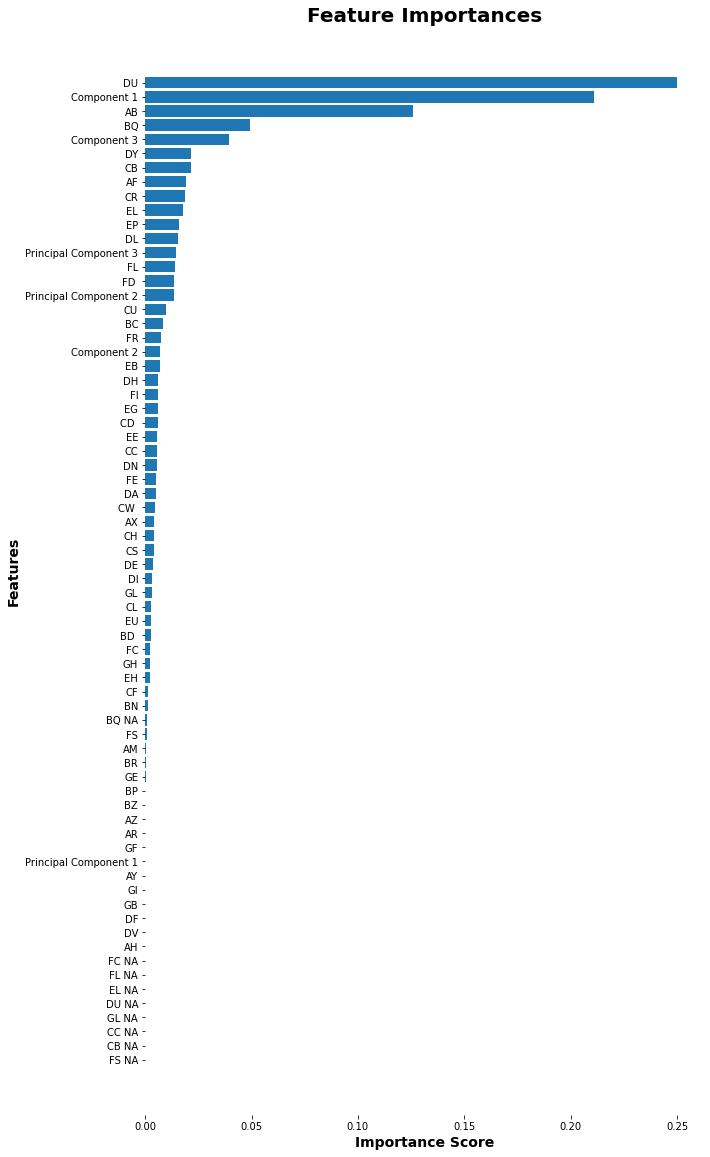

In [313]:
# Create a pandas series with features importances and sort it
importances = pd.Series(gb.feature_importances_, index = x_train_oversampled.columns).sort_values(ascending = True)

# Plot feature importances
plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

In [275]:
models_dict['gb'] = gb

Neural Network

In [257]:
y_train_encoded = to_categorical(y_train_oversampled)
y_val_encoded = to_categorical(y_val)

In [302]:
model = Sequential()

# Add an input layer (matches the number of features in your data)
model.add(Dense(64, activation = 'relu', input_shape = (x_train_oversampled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Add one hidden layer
model.add(Dense(32, activation = 'tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Add one hidden layer
model.add(Dense(16, activation = 'tanh'))

# Add one hidden layer
model.add(Dense(8, activation = 'tanh'))

# Add an output layer with one neuron and sigmoid activation function (for binary classification)
model.add(Dense(2, activation = 'softmax'))

# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Create a callback to save the model's weights
checkpoint = ModelCheckpoint('model_weights_best.h5',  # where to save the weights
                             monitor='val_loss',  # quantity to monitor
                             save_best_only=True,  # only save the best weights
                             mode='min',  # mode='min' for minimizing loss
                             verbose=1)  # print out updates

# Train the model
model.fit(x_train_oversampled, y_train_encoded, 
          epochs=100, 
          batch_size=32, 
          verbose=1, 
          validation_data=(x_val, y_val_encoded), 
          callbacks=[checkpoint]) 

# Train the model
model.fit(x_train_oversampled, y_train_encoded, epochs = 100, batch_size = 32, verbose = 1, validation_data = (x_val, y_val_encoded))

# Predict on validation set
predictions = model.predict(x_val)

Epoch 1/100


2023-06-02 22:01:33.032752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.8428

2023-06-02 22:01:35.025779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.90416, saving model to model_weights_best.h5
26/26 [==============================] - 3s 65ms/step - loss: 0.3914 - accuracy: 0.8428 - val_loss: 0.9042 - val_accuracy: 0.6452
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9275
Epoch 2: val_loss improved from 0.90416 to 0.66098, saving model to model_weights_best.h5
26/26 [==============================] - 1s 24ms/step - loss: 0.2168 - accuracy: 0.9275 - val_loss: 0.6610 - val_accuracy: 0.7500
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9533
Epoch 3: val_loss improved from 0.66098 to 0.42378, saving model to model_weights_best.h5
26/26 [==============================] - 1s 21ms/step - loss: 0.1495 - accuracy: 0.9533 - val_loss: 0.4238 - val_accuracy: 0.8226
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9484
Epoch 4: val_loss improved from 0.42378 to 0.36996, saving

2023-06-02 22:02:49.174481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [303]:
evaluate_model_performance(y_val, np.argmax(predictions, axis = 1))

ROC AUC Score: 0.92
Accuracy: 0.96
Precision: 0.90
Recall: 0.86
F1 Score: 0.88


(0.9220142602495544,
 0.9596774193548387,
 0.9047619047619048,
 0.8636363636363636,
 0.8837209302325582)

In [304]:
models_dict['nn'] = model

## Checking Predictions

In [279]:
class_0 = []
class_1 = []
prediction = []
for row in gb.predict_proba(x_val):
    class_0.append(row[0])
    class_1.append(row[1])
    prediction.append(np.argmax(row))
    

In [280]:
x_val_check = x_val.copy()

In [281]:
x_val_check['class_0'] = class_0
x_val_check['class_1'] = class_1
x_val_check['prediction'] = prediction 

x_val_check = x_val_check[x_val_check['prediction'] != y_val].sort_values(by = 'class_0')

In [282]:
x_val_check

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GL NA,Principal Component 1,Principal Component 2,Principal Component 3,Component 1,Component 2,Component 3,class_0,class_1,prediction
325,0.736724,0.757774,1.436346,0.088313,2.250189,0.656392,2.313644,-0.360044,-0.832691,-0.315629,...,0.0,3.847444,-0.556655,-2.254345,5.141848,2.222537,7.899397,0.000031,0.999969,1
585,2.317108,1.503537,1.974562,0.140576,-0.488129,0.207984,-0.587024,1.482328,0.883370,-0.979664,...,0.0,2.266880,4.949832,2.783413,3.707348,2.964474,3.666760,0.869463,0.130537,0
274,-0.626481,0.815893,-0.695633,-0.851478,-0.488129,-1.553574,-0.587024,-1.859163,0.236021,1.450303,...,0.0,1.217254,-2.743147,-2.081434,3.562594,0.843929,8.515654,0.960368,0.039632,0
421,0.426909,0.109778,1.963855,-1.724151,-0.488129,0.109355,-0.587024,0.180939,-0.832691,-0.254734,...,0.0,-1.513639,-0.866089,0.545431,2.214004,1.184474,4.919132,0.987938,0.012062,0


In [283]:
for i in x_val_check.index:
    print(i)

325
585
274
421


In [284]:
x_train['Class'] = y_train
x_val['Class'] = y_val
df_combinded = pd.concat([x_train, x_val], axis = 0)

In [295]:
row = 421
n_neighbors = 10
find_nearest_neighbors(df_combinded, row, n_neighbors)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL NA,FS NA,GL NA,Principal Component 1,Principal Component 2,Principal Component 3,Component 1,Component 2,Component 3,Class
421,0.426909,0.109778,1.963855,-1.724151,-0.488129,0.109355,-0.587024,0.180939,-0.832691,-0.254734,...,0.0,-0.063823,0.0,-1.513639,-0.866089,0.545431,2.214004,1.184474,4.919132,1
416,-0.846531,-0.551441,1.911839,-0.862598,-0.488129,-0.271585,-0.587024,1.248823,-0.832691,0.609656,...,0.0,-0.063823,0.0,-2.583374,0.966339,1.842023,2.405185,1.971125,3.437793,0
12,0.559000,-0.264293,1.558152,0.967792,-0.488129,-0.519545,-0.587024,0.421436,-0.832691,0.437472,...,0.0,-0.063823,0.0,1.865060,0.935584,1.160145,4.143613,2.535591,6.911425,0
313,1.399484,0.162439,1.800722,-0.232541,-0.488129,0.447366,-0.587024,0.635231,-0.832691,0.365590,...,0.0,-0.063823,0.0,0.726604,-0.126038,1.591000,3.651320,2.202704,7.005035,1
90,-1.454880,-0.608690,0.039722,0.416654,-0.488129,-0.036486,-0.587024,1.516080,-0.832691,-0.211885,...,0.0,-0.063823,0.0,-0.843944,0.022703,-0.559997,3.881594,0.637803,6.990204,0
459,-0.509441,-0.693079,-0.695633,-0.630802,-0.488129,0.431927,-0.587024,2.469087,-0.832691,1.035300,...,0.0,-0.063823,0.0,1.090524,-0.706221,-0.136729,4.243049,1.695152,7.176996,0
566,-0.143425,-0.532653,1.967888,-1.174909,0.017692,-0.959962,-0.587024,1.135677,-0.832691,0.029441,...,0.0,-0.063823,0.0,-1.949306,2.852614,1.725369,2.661206,1.861383,3.485517,0
254,-1.236629,-0.445794,0.412359,-0.725944,-0.488129,0.773773,-0.587024,0.111190,-0.832691,-0.573033,...,0.0,-0.063823,0.0,-3.237120,-0.045810,1.185023,2.040678,1.646154,3.427182,0
164,-0.072898,0.256762,0.470460,-0.241490,-0.488129,0.180994,1.896648,1.520216,0.793699,0.587724,...,0.0,-0.063823,0.0,-1.323546,1.467533,0.508024,3.147249,1.712457,3.975017,0
440,-1.646437,-0.136181,1.301892,-0.957759,-0.488129,-0.353815,-0.587024,0.369346,0.439057,0.171040,...,0.0,-0.063823,0.0,-3.719825,-1.704433,3.012390,1.500517,1.368528,3.906818,0
